# 1. Imports e carregamento do dataset

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# Carregar dataset
file_path = "/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas.csv"
df = pd.read_csv(file_path).query("NO_MUNICIPIO not in ['SAO PAULO','JERIQUARA']")

# Criar coluna de data
df["date"] = pd.to_datetime(df["YYYY"].astype(str) + "-" + df["MM"].astype(str) + "-01")
df = df.sort_values("date").reset_index(drop=True)

print(df.shape)
df.head()


(374616, 16)


,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,date
0,350280,2022,1,ARACATUBA,MEDICO PEDIATRA,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01
1,351620,2022,1,FRANCA,MEDICO OFTALMOLOGISTA,46,35.0,São Paulo,Ribeirão Preto,FRANCA,360459.0,360459.0,163.0,0.000452,0.127615,2022-01-01
2,353060,2022,1,MOGI DAS CRUZES,MEDICO PEDIATRA,119,35.0,São Paulo,São Paulo,MOGI DAS CRUZES,459727.0,459727.0,353.0,0.000768,0.258849,2022-01-01
3,353870,2022,1,PIRACICABA,MEDICO ORTOPEDISTA E TRAUMATOLOGISTA,108,35.0,São Paulo,Campinas,PIRACICABA,419580.0,419580.0,798.0,0.001906,0.257400,2022-01-01
4,351050,2022,1,CARAGUATATUBA,MEDICO OFTALMOLOGISTA,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01


# Incluindo Features

In [37]:
# Índice temporal (para regressão linear)
df["time_index"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]).cumcount() + 1

# Lags e rolling
df["lag1"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].shift(1)
df["rolling3"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].transform(lambda x: x.rolling(3).mean())
df["rolling6"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].transform(lambda x: x.rolling(6).mean())
df["rolling12"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].transform(lambda x: x.rolling(12).mean())
df["rolling24"] = df.groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"].transform(lambda x: x.rolling(24).mean())


# --- Criar buckets de população (mais detalhado)
bins = [0, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 300000, 400000, 500000, 700000, 1000000, 1500000]
labels = ["0-10k", "10-20k", "20-30k", "30-40k", "40-50k", "50-70k", "70-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-700k", "700k-1M", "1M-1.5M"]
df["POP_BUCKET"] = pd.cut(df["POPULACAO"], bins=bins, labels=labels, include_lowest=True)

# Acima de 0.5 → tudo em um único bucket "0.5+"
bins = list(np.arange(0, 0.505, 0.01))  
bins.append(np.inf)

# Labels: detalhados até 0.5, e "0.5+" para o resto
labels = []
for i in range(len(bins)-1):
    low, high = bins[i], bins[i+1]
    if high == np.inf:
        labels.append("0.5+")
    else:
        labels.append(f"{low:.3f}-{high:.3f}")

# Criar a coluna de bucket
df["PROF_BUCKET"] = pd.cut(
    df["PROFISSIONAIS_POR_1000"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Tendência temporal geral

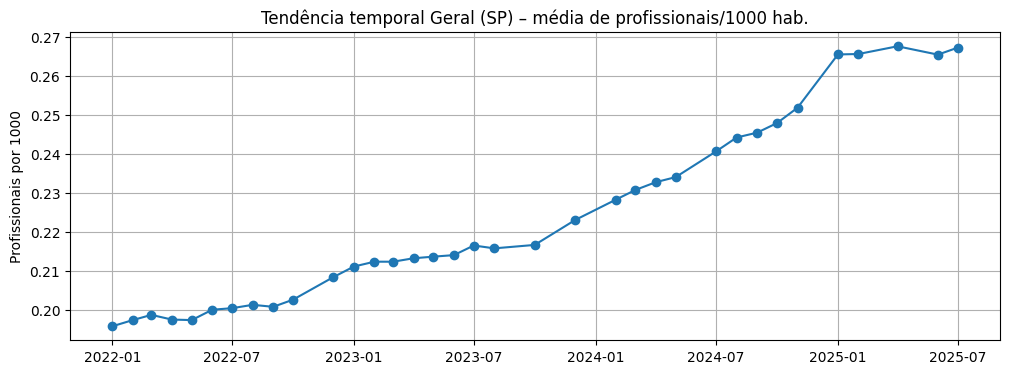

In [22]:
# Série temporal agregada por mês (média geral)
ts = df.groupby("date")["PROFISSIONAIS_POR_1000"].mean()

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, marker="o")
plt.title("Tendência temporal Geral (SP) – média de profissionais/1000 hab.")
plt.ylabel("Profissionais por 1000")
plt.grid(True)
plt.show()

# Análise da taxa de profissionais/mil habitantes

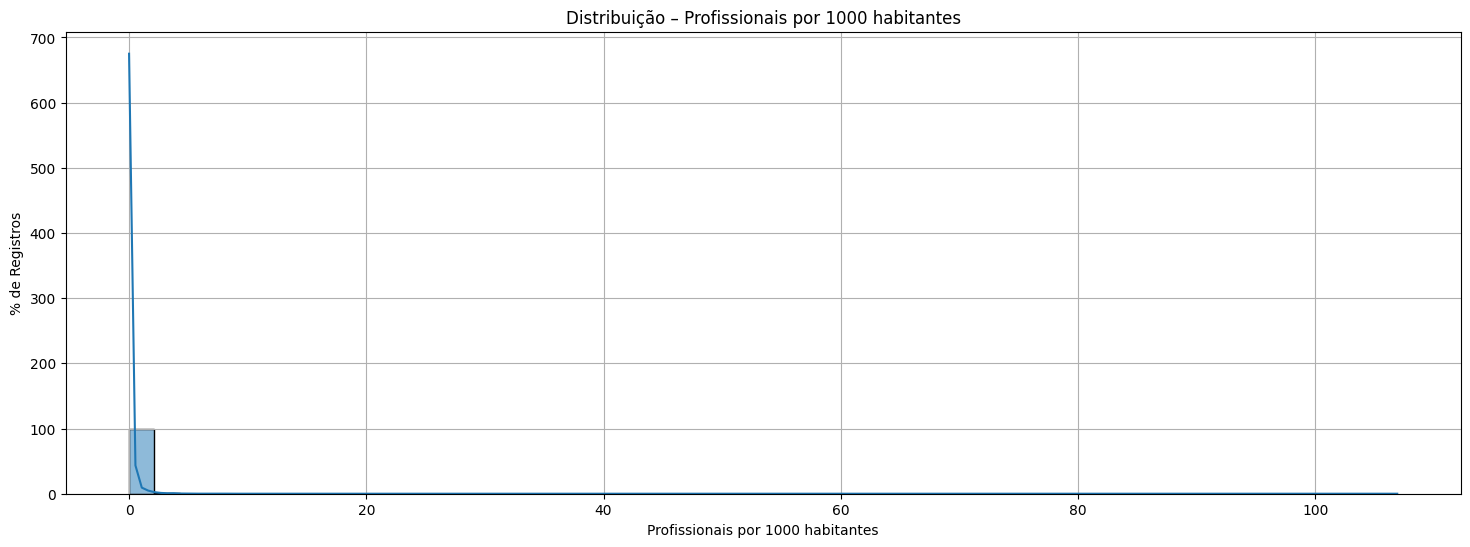

Total de registros válidos: 286460
Registros com profissionais/1000 < 0.5: 260746 (91.02%)


In [23]:
# --- Plot distribuição de profissionais por 1000 habitantes (valores brutos) ---
plt.figure(figsize=(18,6))
sns.histplot(df["PROFISSIONAIS_POR_1000"].dropna(), bins=50, kde=True, stat="percent")
plt.title("Distribuição – Profissionais por 1000 habitantes")
plt.xlabel("Profissionais por 1000 habitantes")
plt.ylabel("% de Registros")
plt.grid(True)

# Forçar notação normal no eixo X
plt.ticklabel_format(style="plain", axis="x")

plt.show()

# --- Calcular percentual abaixo de um limite ---
limit_prof = 0.5
total_registros = df["PROFISSIONAIS_POR_1000"].notna().sum()
abaixo_limite = (df["PROFISSIONAIS_POR_1000"] < limit_prof).sum()
pct_abaixo = (abaixo_limite / total_registros) * 100

print(f"Total de registros válidos: {total_registros}")
print(f"Registros com profissionais/1000 < {limit_prof}: {abaixo_limite} ({pct_abaixo:.2f}%)")


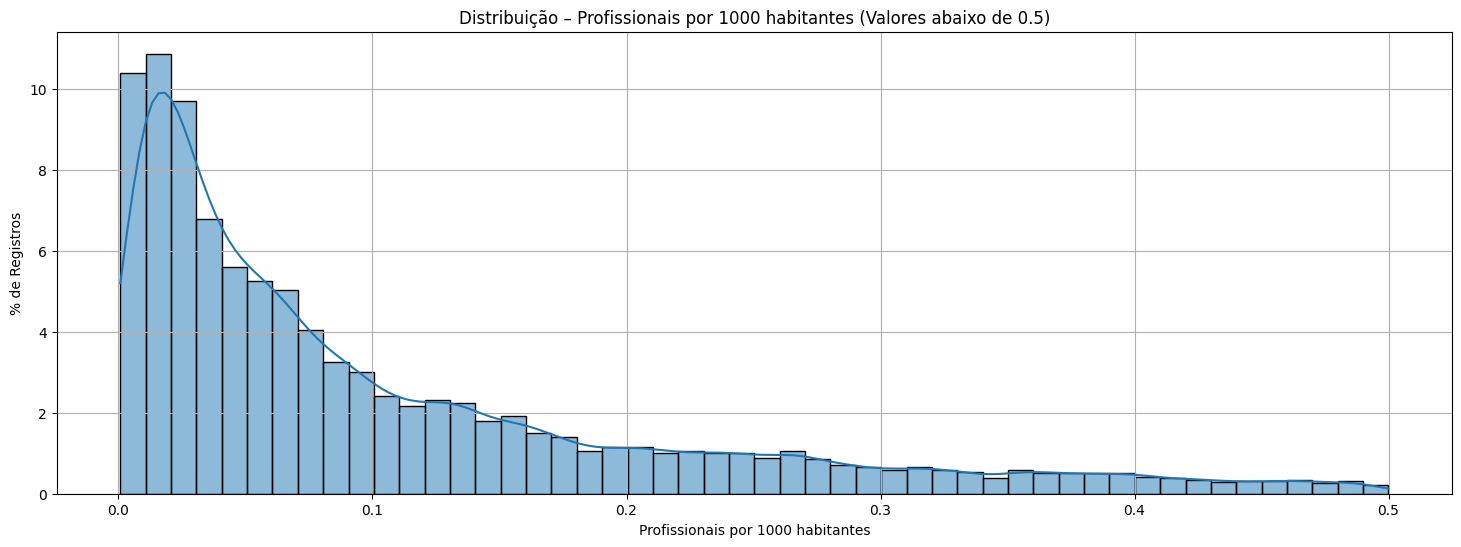

Total de registros válidos: 260746
Registros com profissionais/1000 < 0.2: 213651 (81.94%)


In [24]:
df_to_plot = df.query("PROFISSIONAIS_POR_1000 < 0.5").copy()
# --- Plot distribuição de profissionais por 1000 habitantes (valores brutos) ---
plt.figure(figsize=(18,6))
sns.histplot(df_to_plot["PROFISSIONAIS_POR_1000"].dropna(), bins=50, kde=True, stat="percent")
plt.title("Distribuição – Profissionais por 1000 habitantes (Valores abaixo de 0.5)")
plt.xlabel("Profissionais por 1000 habitantes")
plt.ylabel("% de Registros")
plt.grid(True)

# Forçar notação normal no eixo X
plt.ticklabel_format(style="plain", axis="x")

plt.show()

# --- Calcular percentual abaixo de um limite ---
limit_prof = 0.2
total_registros = df_to_plot["PROFISSIONAIS_POR_1000"].notna().sum()
abaixo_limite = (df_to_plot["PROFISSIONAIS_POR_1000"] < limit_prof).sum()
pct_abaixo = (abaixo_limite / total_registros) * 100

print(f"Total de registros válidos: {total_registros}")
print(f"Registros com profissionais/1000 < {limit_prof}: {abaixo_limite} ({pct_abaixo:.2f}%)")


/var/folders/q4/r947g97d1mdblr_m7b44wpfc0000gp/T/ipykernel_79878/3555716765.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="POP_BUCKET", y="PROF_BUCKET", data=df_to_boxplot, palette="Set2")


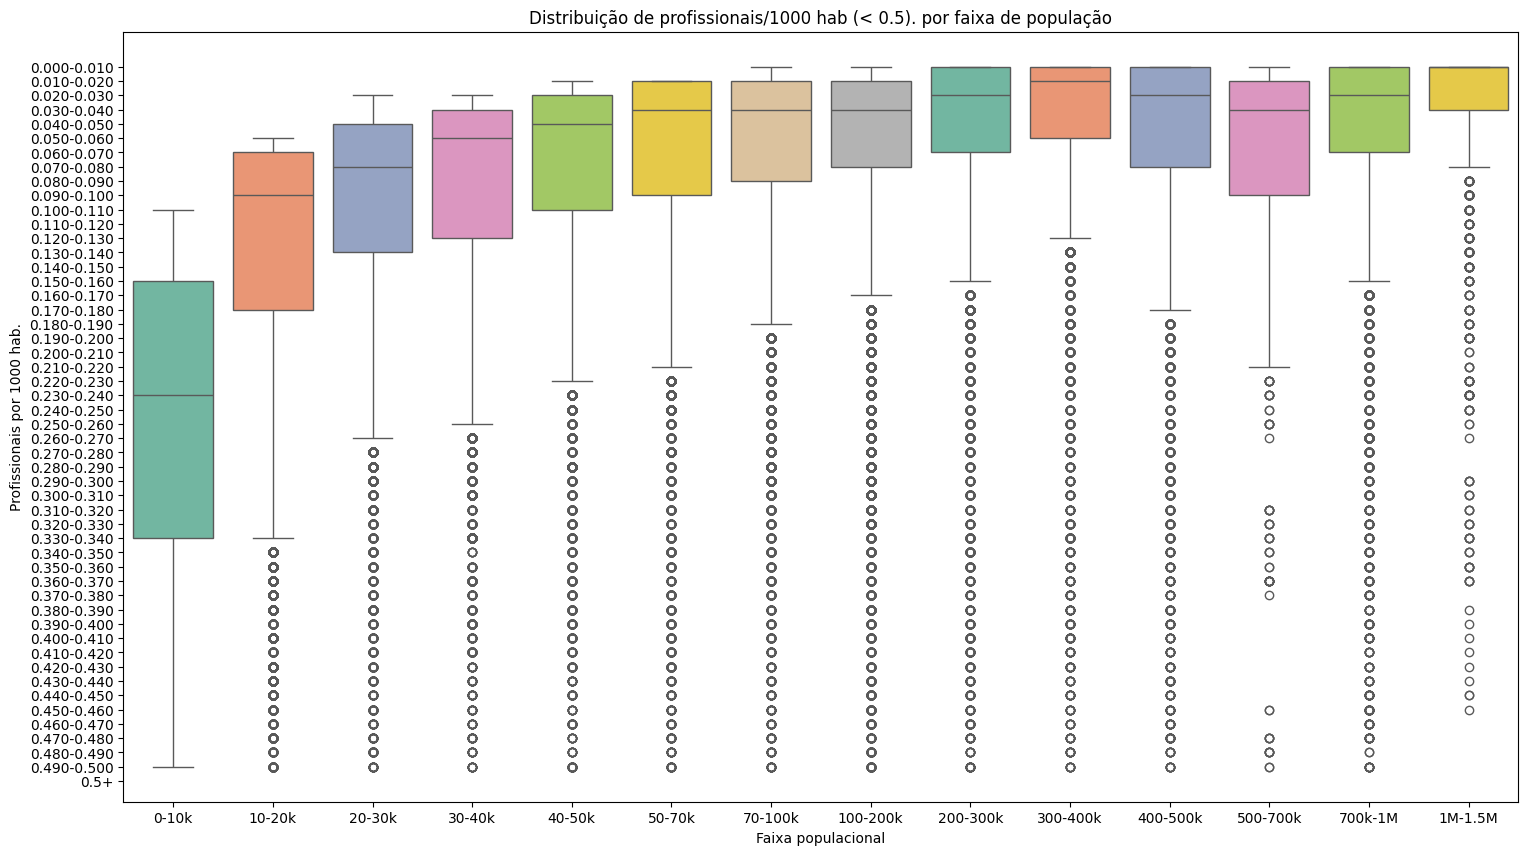

In [11]:
df_to_boxplot = df.copy()
# --- Criar buckets de população (mais detalhado)
bins = [0, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 300000, 400000, 500000, 700000, 1000000, 1500000]
labels = ["0-10k", "10-20k", "20-30k", "30-40k", "40-50k", "50-70k", "70-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-700k", "700k-1M", "1M-1.5M"]
df_to_boxplot["POP_BUCKET"] = pd.cut(df["POPULACAO"], bins=bins, labels=labels, include_lowest=True)

# Até 0.5 → passo de 0.005
bins = list(np.arange(0, 0.505, 0.01))  

# Acima de 0.5 → tudo em um único bucket "0.5+"
bins.append(np.inf)

# Labels: detalhados até 0.5, e "0.5+" para o resto
labels = []
for i in range(len(bins)-1):
    low, high = bins[i], bins[i+1]
    if high == np.inf:
        labels.append("0.5+")
    else:
        labels.append(f"{low:.3f}-{high:.3f}")

# Criar a coluna de bucket
df_to_boxplot["PROF_BUCKET"] = pd.cut(
    df_to_boxplot["PROFISSIONAIS_POR_1000"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_to_boxplot = df_to_boxplot.query("PROFISSIONAIS_POR_1000 < 0.5")
plt.figure(figsize=(18,10))
sns.boxplot(x="POP_BUCKET", y="PROF_BUCKET", data=df_to_boxplot, palette="Set2")
plt.title("Distribuição de profissionais/1000 hab (< 0.5). por faixa de população")
plt.xlabel("Faixa populacional")
plt.ylabel("Profissionais por 1000 hab.")
plt.show()

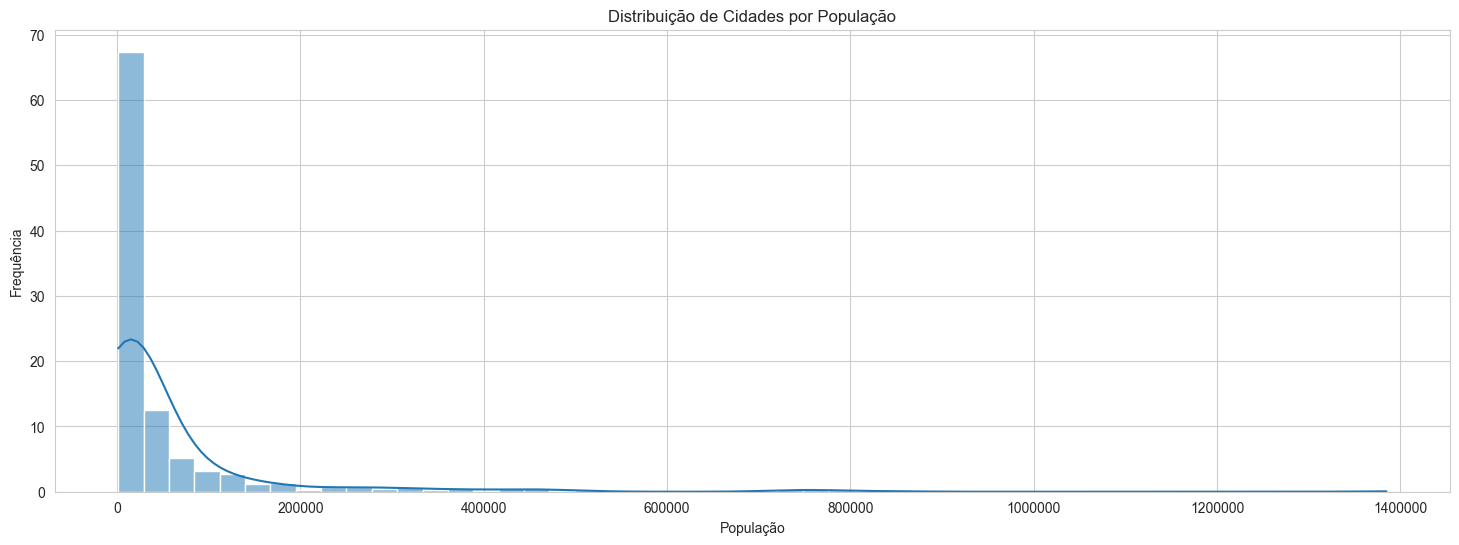

Total de cidades com dados: 506
Cidades com população < 20000: 60.27667984189723 (60.28%)


In [127]:
#plot distribuicao da populacao
df_to_plot = (
    df.groupby("NO_MUNICIPIO", as_index=False)
      .agg(POPULACAO=("POPULACAO", "max"))
      .dropna(subset=["POPULACAO"])
)
plt.figure(figsize=(18,6))
sns.histplot(df_to_plot["POPULACAO"], bins=50, kde=True , stat="percent")
plt.title("Distribuição de Cidades por População")
plt.xlabel("População")
plt.ylabel("Frequência")
plt.grid(True)

# Forçar notação normal no eixo Y
plt.ticklabel_format(style="plain", axis="x")

plt.show()

#Calcular percentual de cidades com populacao abaixo de 10k
limit_populacao = 20000
total_cidades = len(df_to_plot)
cidades_abaixo_limite = (df_to_plot["POPULACAO"] < limit_populacao).sum()
cidades_abaixo_limite = (cidades_abaixo_limite / total_cidades) * 100

print(f"Total de cidades com dados: {total_cidades}")
print(f"Cidades com população < {limit_populacao}: {cidades_abaixo_limite} ({cidades_abaixo_limite:.2f}%)")


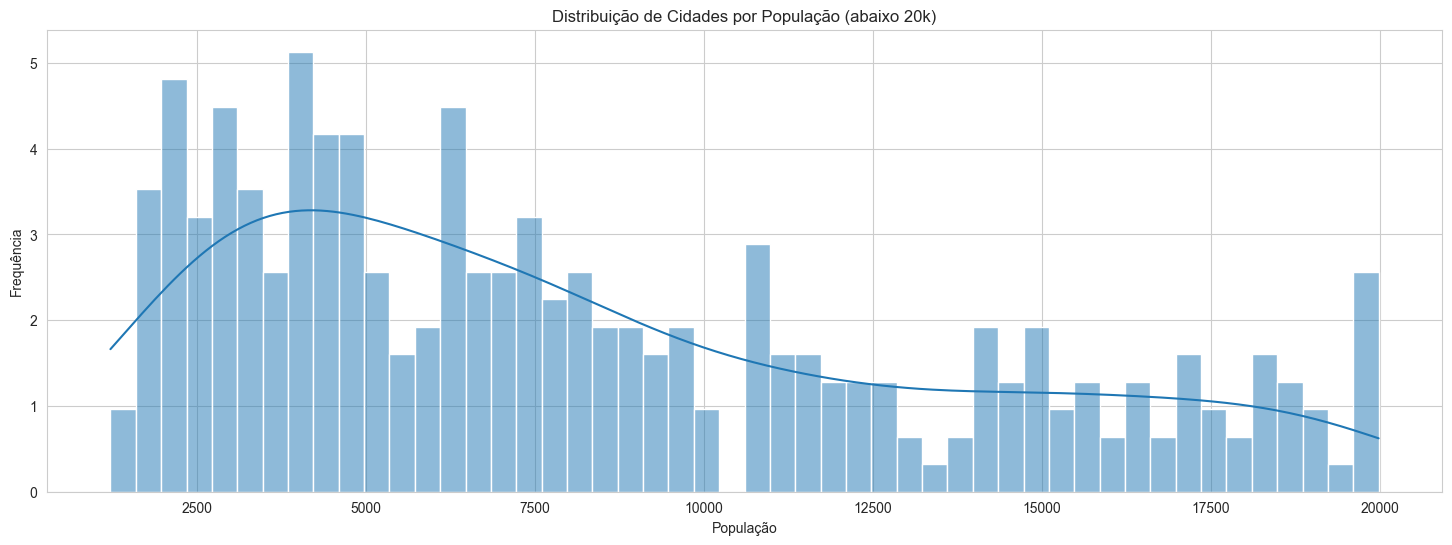

Total de cidades com dados: 312
Cidades com população < 20000: 100.0 (100.00%)


In [132]:
#plot distribuicao da populacao
df_to_plot = (
    df.query("POPULACAO <= 20000").groupby("NO_MUNICIPIO", as_index=False)
      .agg(POPULACAO=("POPULACAO", "max"))
      .dropna(subset=["POPULACAO"])
)
plt.figure(figsize=(18,6))
sns.histplot(df_to_plot["POPULACAO"], bins=50, kde=True , stat="percent")
plt.title("Distribuição de Cidades por População (abaixo 20k)")
plt.xlabel("População")
plt.ylabel("Frequência")
plt.grid(True)

# Forçar notação normal no eixo Y
plt.ticklabel_format(style="plain", axis="x")

plt.show()

#Calcular percentual de cidades com populacao abaixo de 10k
limit_populacao = 20000
total_cidades = len(df_to_plot)
cidades_abaixo_limite = (df_to_plot["POPULACAO"] < limit_populacao).sum()
cidades_abaixo_limite = (cidades_abaixo_limite / total_cidades) * 100

print(f"Total de cidades com dados: {total_cidades}")
print(f"Cidades com população < {limit_populacao}: {cidades_abaixo_limite} ({cidades_abaixo_limite:.2f}%)")


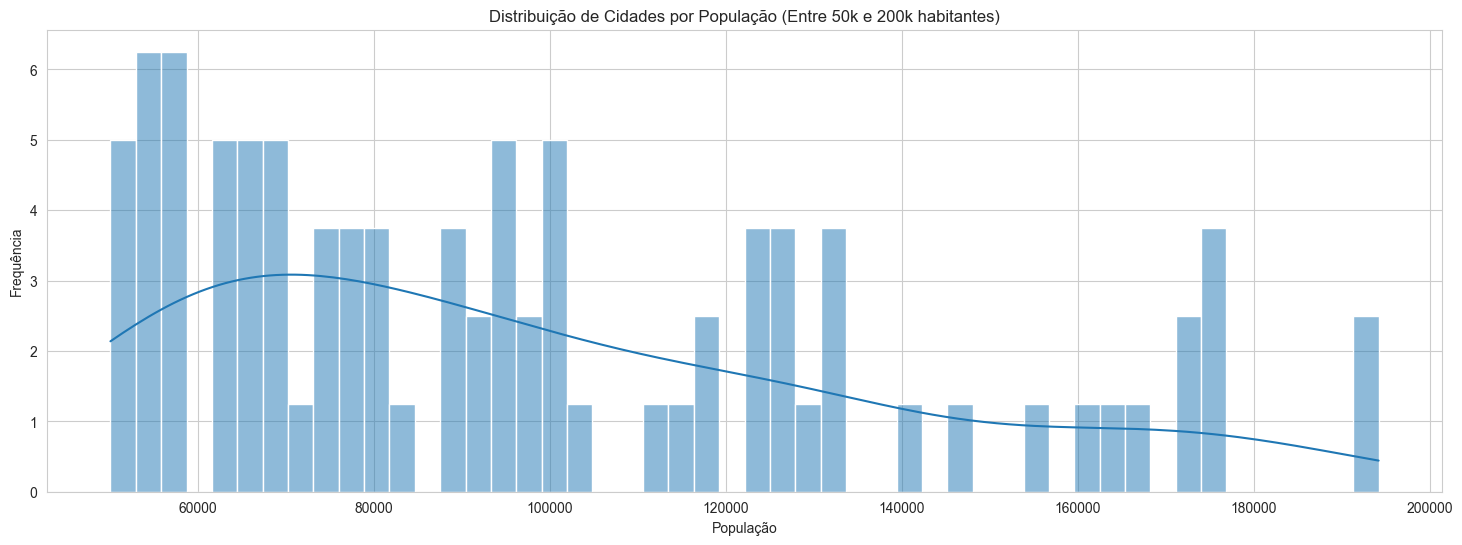

Total de cidades com dados: 80
Cidades com população < 20000: 0.0 (0.00%)


In [136]:
#plot distribuicao da populacao
df_to_plot = (
    df.query("POPULACAO >= 50000 and POPULACAO<200000").groupby("NO_MUNICIPIO", as_index=False)
      .agg(POPULACAO=("POPULACAO", "max"))
      .dropna(subset=["POPULACAO"])
)
plt.figure(figsize=(18,6))
sns.histplot(df_to_plot["POPULACAO"], bins=50, kde=True , stat="percent")
plt.title("Distribuição de Cidades por População (Entre 50k e 200k habitantes)")
plt.xlabel("População")
plt.ylabel("Frequência")
plt.grid(True)

# Forçar notação normal no eixo Y
plt.ticklabel_format(style="plain", axis="x")

plt.show()

#Calcular percentual de cidades com populacao abaixo de 10k
limit_populacao = 20000
total_cidades = len(df_to_plot)
cidades_abaixo_limite = (df_to_plot["POPULACAO"] < limit_populacao).sum()
cidades_abaixo_limite = (cidades_abaixo_limite / total_cidades) * 100

print(f"Total de cidades com dados: {total_cidades}")
print(f"Cidades com população < {limit_populacao}: {cidades_abaixo_limite} ({cidades_abaixo_limite:.2f}%)")


# Correlação de variáveis


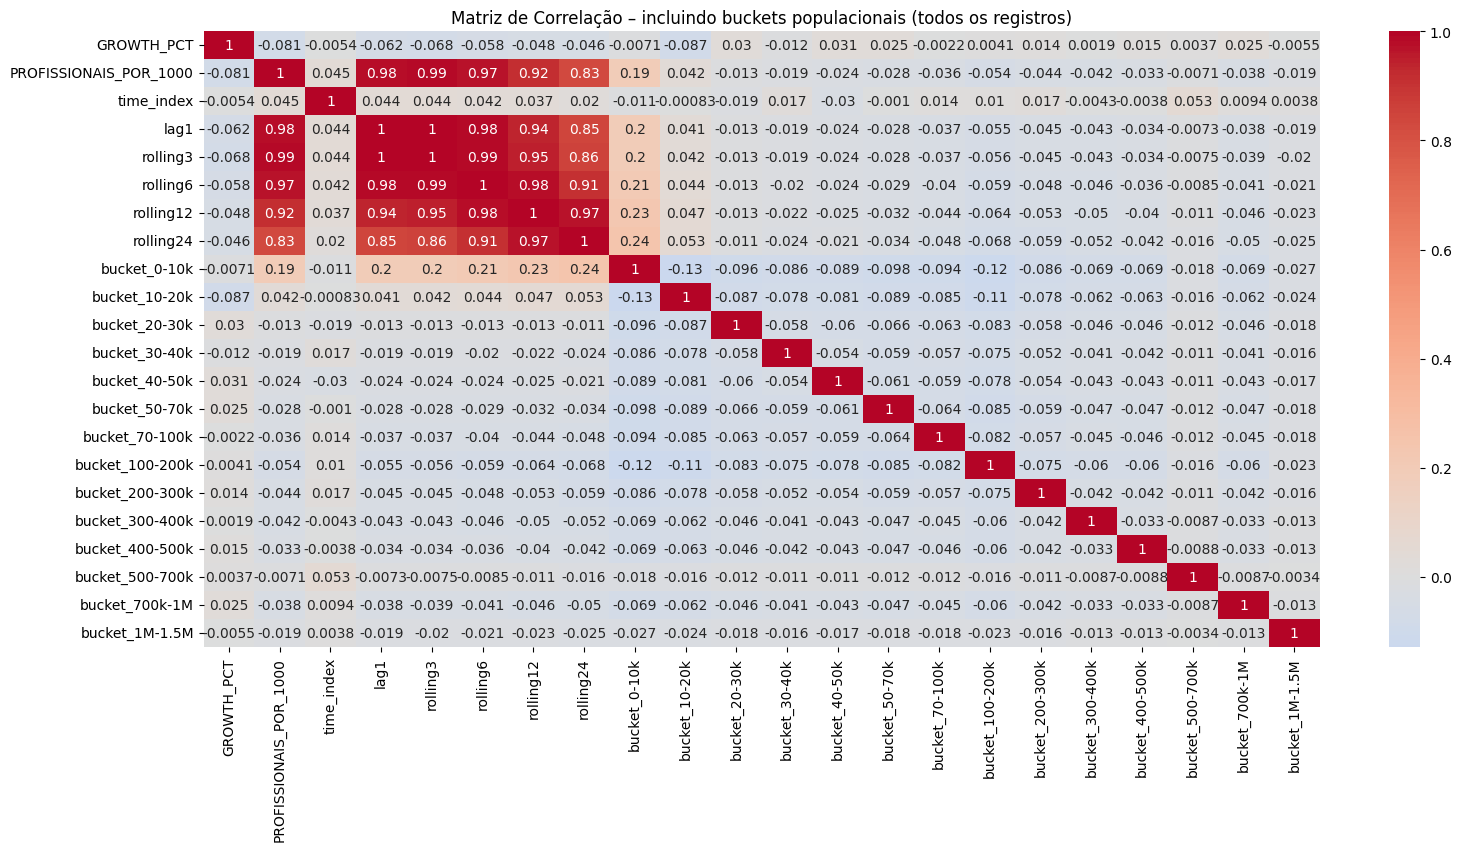

In [ ]:
# --- Criar dummies (garantindo que vira int)
df_dummies = pd.get_dummies(df["POP_BUCKET"], prefix="bucket").astype(int)

# --- Concatenar
df_with_buckets = pd.concat([df, df_dummies], axis=1)

# --- Selecionar só numéricas (inclui os buckets agora)
num_cols = df_with_buckets.select_dtypes(include=["float64","int64"]).columns.drop(["CO_UF", "CO_MUNICIPIO_SEM_DIGITO", "YYYY", "MM", "TOTAL_PROFISSIONAIS", "POPULACAO", "GROWTH_ABS", "POPULACAO_MENSAL"])

# --- Heatmap
plt.figure(figsize=(18,8))
sns.heatmap(df_with_buckets[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação – incluindo buckets populacionais (todos os registros)")
plt.show()


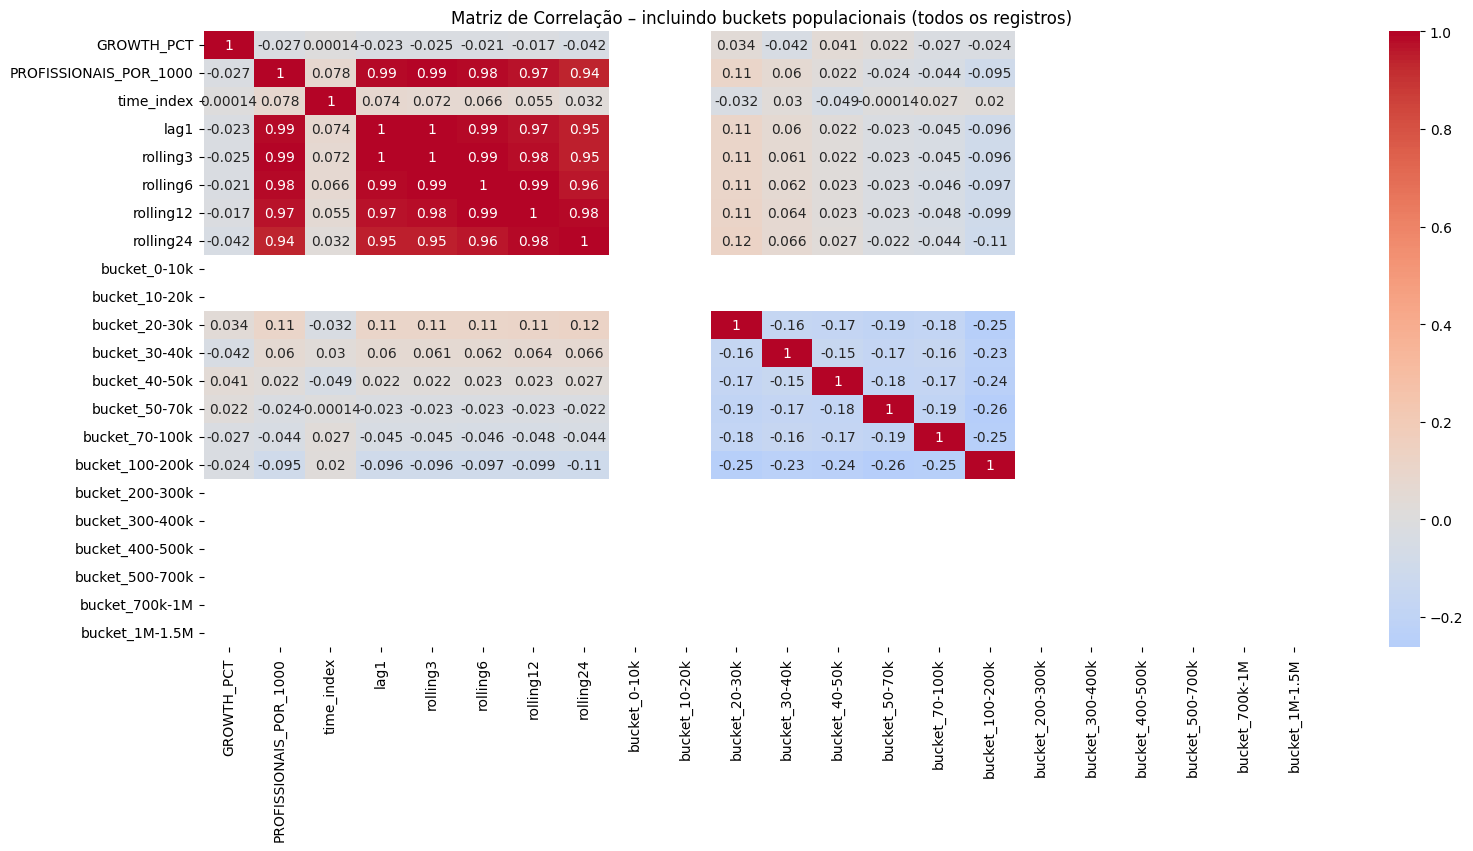

In [ ]:
df_filtered = df.query("POPULACAO >=20000 and POPULACAO <200000 and PROFISSIONAIS_POR_1000 > 0 and PROFISSIONAIS_POR_1000 <0.5")

# --- Criar dummies (garantindo que vira int)
df_dummies = pd.get_dummies(df_filtered["POP_BUCKET"], prefix="bucket").astype(int)

# --- Concatenar
df_with_buckets = pd.concat([df_filtered, df_dummies], axis=1)

# --- Selecionar só numéricas (inclui os buckets agora)
num_cols = df_with_buckets.select_dtypes(include=["float64","int64"]).columns.drop(["CO_UF", "CO_MUNICIPIO_SEM_DIGITO", "YYYY", "MM", "TOTAL_PROFISSIONAIS", "POPULACAO", "GROWTH_ABS", "POPULACAO_MENSAL"])

# --- Heatmap
plt.figure(figsize=(18,8))
sns.heatmap(df_with_buckets[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação – incluindo buckets populacionais (todos os registros)")
plt.show()


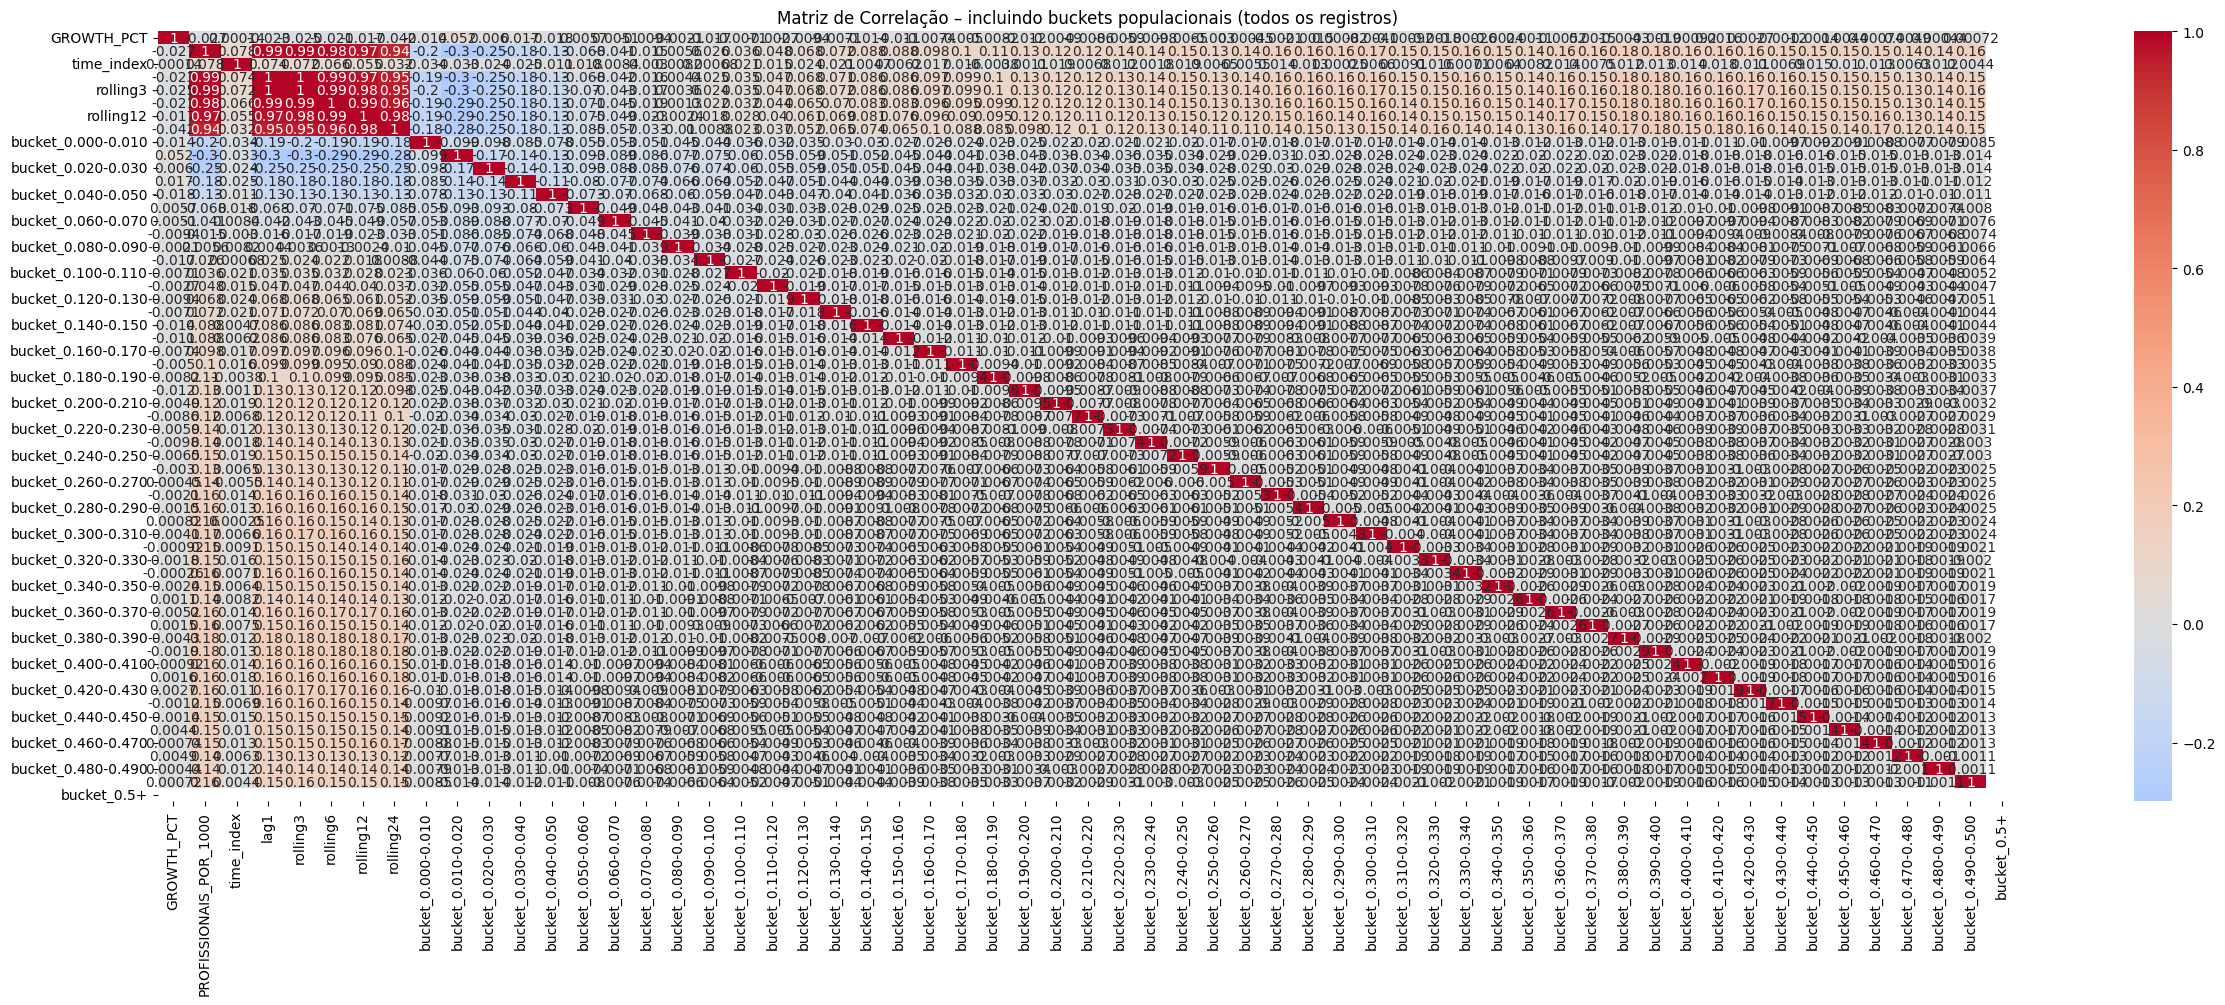

In [40]:
df_filtered = df.query("POPULACAO >=20000 and POPULACAO <200000 and PROFISSIONAIS_POR_1000 > 0 and PROFISSIONAIS_POR_1000 <0.5")

# --- Criar dummies (garantindo que vira int)
df_dummies = pd.get_dummies(df_filtered["PROF_BUCKET"], prefix="bucket").astype(int)

# --- Concatenar
df_with_buckets = pd.concat([df_filtered, df_dummies], axis=1)

# --- Selecionar só numéricas (inclui os buckets agora)
num_cols = df_with_buckets.select_dtypes(include=["float64","int64"]).columns.drop(["CO_UF", "CO_MUNICIPIO_SEM_DIGITO", "YYYY", "MM", "TOTAL_PROFISSIONAIS", "POPULACAO", "GROWTH_ABS", "POPULACAO_MENSAL"])

# --- Heatmap
plt.figure(figsize=(30,10))
sns.heatmap(df_with_buckets[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação – incluindo buckets populacionais (todos os registros)")
plt.show()


In [1]:
# Remover NAs gerados
df_model = df.dropna(subset=["POPULACAO_MENSAL","GROWTH_PCT","lag1","rolling3","PROFISSIONAIS_POR_1000","POP_BUCKET"]).copy()

features_rf = ["POPULACAO_MENSAL","GROWTH_PCT","lag1","rolling3", "POP_BUCKET"]
features_lr = features_rf + ["time_index"]
target = "PROFISSIONAIS_POR_1000"


NameError: name 'df' is not defined

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_models(df_sub):
    # Garantir ordem temporal
    df_sub = df_sub.sort_values("date").reset_index(drop=True)
    
    # Checagem mínima (>= 12 pontos)
    if len(df_sub) < 12:
        return None
    
    # Features/target conforme seu setup atual
    X_rf = df_sub[features_rf]
    X_lr = df_sub[features_lr]
    y    = df_sub[target]  # ex.: "target_next_month" ou "PROFISSIONAIS_POR_1000"
    
    # Split temporal
    train_size = int(len(df_sub) * 0.8)
    X_rf_train, X_rf_test = X_rf.iloc[:train_size], X_rf.iloc[train_size:]
    X_lr_train, X_lr_test = X_lr.iloc[:train_size], X_lr.iloc[train_size:]
    y_train, y_test       = y.iloc[:train_size], y.iloc[train_size:]
    dates_train           = df_sub["date"].iloc[:train_size]
    dates_test            = df_sub["date"].iloc[train_size:]
    
    # ----- Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_rf_train, y_train)
    y_pred_rf_train = rf.predict(X_rf_train)
    y_pred_rf_test  = rf.predict(X_rf_test)
    
    # ----- Linear Regression
    lr = LinearRegression()
    lr.fit(X_lr_train, y_train)
    y_pred_lr_train = lr.predict(X_lr_train)
    y_pred_lr_test  = lr.predict(X_lr_test)
    
    # Métricas (teste)
    results = {
        "MAE_RF":  mean_absolute_error(y_test, y_pred_rf_test),
        "RMSE_RF": root_mean_squared_error(y_test, y_pred_rf_test),
        "R2_RF":   r2_score(y_test, y_pred_rf_test),
        "MAE_LR":  mean_absolute_error(y_test, y_pred_lr_test),
        "RMSE_LR": root_mean_squared_error(y_test, y_pred_lr_test),
        "R2_LR":   r2_score(y_test, y_pred_lr_test),
        
        # Para plot
        "dates_full": df_sub["date"].values,
        "y_full":     y.values,
        
        "dates_train": dates_train.values,
        "y_train":     y_train.values,
        "y_pred_rf_train": y_pred_rf_train,
        "y_pred_lr_train": y_pred_lr_train,
        
        "dates_test": dates_test.values,
        "y_test":     y_test.values,
        "y_pred_rf_test":  y_pred_rf_test,
        "y_pred_lr_test":  y_pred_lr_test,
        
        # Modelos (útil se quiser refazer previsões out-of-sample depois)
        "model_rf": rf,
        "model_lr": lr
    }
    return results


In [73]:
#QUANTIDADE DE MESES, MIN, MAX PARA CADA CIDADE
city_list = df_model[["NO_MUNICIPIO","date"]].drop_duplicates()
city_list["month"] = city_list["date"].dt.to_period("M")
city_list = city_list.groupby("NO_MUNICIPIO")["month"].agg(["count","min","max"]).reset_index()
city_list_acima_24_meses = city_list[city_list["count"] >= 24]
city_list_acima_24_meses

,NO_MUNICIPIO,count,min,max
0,ALAMBARI,33,2022-03,2025-07
1,ALUMINIO,33,2022-03,2025-07
2,ARCO-IRIS,33,2022-03,2025-07
3,ASPASIA,33,2022-03,2025-07
4,BOM SUCESSO DE ITARARE,33,2022-03,2025-07
...,...,...,...,...
501,VISTA ALEGRE DO ALTO,33,2022-03,2025-07
502,VITORIA BRASIL,33,2022-03,2025-07
503,VOTORANTIM,33,2022-03,2025-07
504,VOTUPORANGA,33,2022-03,2025-07


In [74]:
cities_to_test = city_list_acima_24_meses["NO_MUNICIPIO"].tolist()
# specialty = "MEDICO CLINICO"

results_dict = {}
for city in cities_to_test:
    df_sub = df_model.query("NO_MUNICIPIO == @city").reset_index(drop=True)
    res = evaluate_models(df_sub)
    if res:
        # se quiser a tabela só com métricas, filtra chaves numéricas
        results_dict[city] = {k: v for k, v in res.items() if k in ["MAE_RF","RMSE_RF","R2_RF","MAE_LR","RMSE_LR","R2_LR"]}
results_df = pd.DataFrame(results_dict).T
results_df.sort_values("MAE_LR", ascending=False)


ValueError: could not convert string to float: '0-10k'

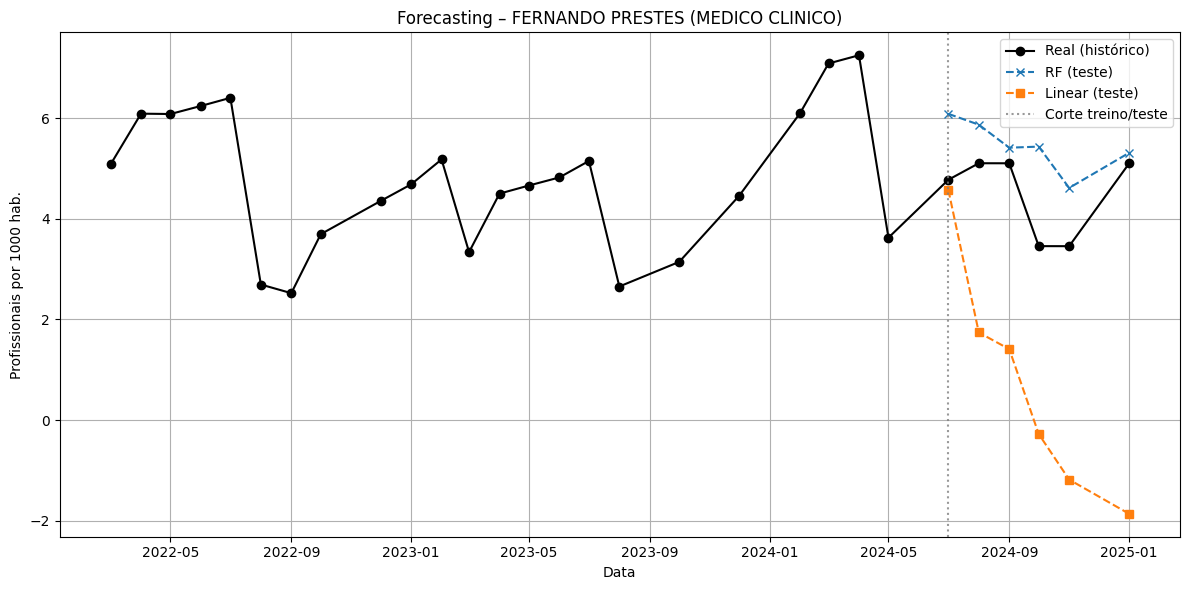

In [15]:
import matplotlib.pyplot as plt

city = "FERNANDO PRESTES"
df_sub = df_model.query(
    "NO_MUNICIPIO == @city and DS_ATIVIDADE_PROFISSIONAL == @specialty"
).reset_index(drop=True)

res = evaluate_models(df_sub)

plt.figure(figsize=(12,6))

# HISTÓRICO COMPLETO (real)
plt.plot(res["dates_full"], res["y_full"], color="black", marker="o", label="Real (histórico)")

# PREVISÕES NO TREINO (linha fina / transparência)
# plt.plot(res["dates_train"], res["y_pred_rf_train"], linestyle="--", alpha=0.6, label="RF (treino)")
# plt.plot(res["dates_train"], res["y_pred_lr_train"], linestyle="--", alpha=0.6, label="Linear (treino)")

# PREVISÕES NO TESTE (destaque)
plt.plot(res["dates_test"], res["y_pred_rf_test"], "x--", label="RF (teste)")
plt.plot(res["dates_test"], res["y_pred_lr_test"], "s--", label="Linear (teste)")

# Linha vertical no ponto de corte treino/teste
split_date = res["dates_test"][0]
plt.axvline(split_date, color="gray", linestyle=":", alpha=0.8, label="Corte treino/teste")

plt.title(f"Forecasting – {city} ({specialty})")
plt.xlabel("Data")
plt.ylabel("Profissionais por 1000 hab.")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1. Matriz de Correlação

A matriz de correlação mostra que, em municípios menores:

As variáveis de lags (lag1, lag2, lag3) e médias móveis (rolling3, rolling6) são fortemente correlacionadas com PROFISSIONAIS_POR_1000. Isso indica alta redundância entre essas features: elas capturam a mesma informação histórica.

mes_sin e mes_cos mantêm correlação baixa com os demais, o que sugere que a sazonalidade não tem grande peso explicativo em cidades pequenas.

POPULACAO_MENSAL e GROWTH_PCT mostram correlação fraca com a densidade de profissionais, evidenciando que em municípios menores fatores estruturais e locais pesam mais que o crescimento populacional.

2. Resultados de Erro

Os erros médios (MAE, RMSE) se mostraram maiores em cidades <100k do que nos municípios maiores. Já o R², em vários casos, chega a valores negativos na Regressão Linear e bastante baixos em Random Forest. Isso pode ser explicado por:

Menor número absoluto de profissionais → pequenas variações mensais (ex.: entrada ou saída de 2 médicos) representam um grande impacto relativo na métrica por 1.000 habitantes, gerando volatilidade elevada.

Maior sensibilidade ao ruído → em cidades grandes, flutuações individuais se diluem no denominador populacional. Em cidades pequenas, a série é muito mais “instável”, dificultando o aprendizado de tendências claras.

Sazonalidade e políticas locais (ex.: contratação de poucos médicos em um único mês) têm peso desproporcional em cidades pequenas, algo difícil de capturar com modelos genéricos.

3. Comparativo entre Modelos

Random Forest: mesmo com oscilações, consegue capturar parte da variação porque se adapta a padrões não lineares. Porém, sofre quando há pouco dado ou quando os valores são altamente erráticos.

Regressão Linear com time_index: em cidades pequenas, frequentemente apresenta R² negativo, indicando que a tendência linear não explica a variabilidade — os dados são muito ruidosos para que um “ajuste de linha” seja válido.

4. Interpretação

Em resumo:

Acima de 100k habitantes: os modelos conseguem capturar tendências mais estáveis. A variabilidade relativa é menor, e métricas como MAE e RMSE ficam em escala reduzida, com R² geralmente positivo.

Abaixo de 100k habitantes: o problema é mais volátil e instável, e isso eleva os erros e prejudica as métricas de ajuste. A previsão para cidades menores é mais incerta, o que deve ser explicitado como limitação do modelo no TCC.

# Rodando para todo o conjunto

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

dfg = df_model.sort_values("date").dropna(
    subset=features_rf + ["PROFISSIONAIS_POR_1000", "NO_MUNICIPIO", "DS_ATIVIDADE_PROFISSIONAL"]
).copy()

# corte temporal global (80% treino, 20% teste)
cut_idx = int(dfg["date"].nunique() * 0.8)
cut_date = sorted(dfg["date"].unique())[cut_idx]

X = dfg[["POPULACAO_MENSAL","GROWTH_PCT","lag1","rolling3","NO_MUNICIPIO","DS_ATIVIDADE_PROFISSIONAL","time_index"]]
y = dfg["PROFISSIONAIS_POR_1000"]

X_train = X[dfg["date"] <  cut_date]
y_train = y[dfg["date"] <  cut_date]
X_test  = X[dfg["date"] >= cut_date]
y_test  = y[dfg["date"] >= cut_date]

# One-hot nas categóricas 
cat_cols = ["NO_MUNICIPIO","DS_ATIVIDADE_PROFISSIONAL", "POP_BUCKET"]
num_cols = ["POPULACAO_MENSAL","GROWTH_PCT","lag1","rolling3","time_index"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

pipe = Pipeline([
    ("pre", pre),
    ("lr", LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


“No contexto analisado, observamos sinais de underfitting nos modelos lineares locais, que não capturam adequadamente a variabilidade temporal das cidades pequenas, resultando em R² negativo. Já os modelos baseados em Random Forest apresentaram risco de overfitting em cenários com séries muito curtas, ajustando-se ao ruído histórico mas com baixa capacidade de generalização. O modelo global, por outro lado, atenua ambos os problemas ao aprender padrões mais robustos a partir de um volume maior de dados.”

## Comparação entre Modelos Globais e Locais

### 1. Contexto do Experimento
Foram avaliados dois cenários de modelagem preditiva para a disponibilidade de profissionais de saúde por 1.000 habitantes:

- **Modelo Global**: um único modelo treinado considerando todas as cidades em conjunto.
- **Modelos Locais**: modelos individuais treinados separadamente para cada cidade.

### 2. Métricas de Avaliação
Foram utilizadas três métricas principais:

- **MAE (Mean Absolute Error)**: mede o erro médio absoluto. Valores próximos de **0** indicam previsões mais próximas da realidade.
- **RMSE (Root Mean Squared Error)**: semelhante ao MAE, mas penaliza mais os erros grandes. Valores menores indicam melhor desempenho.
- **R² (Coeficiente de Determinação)**: mede a proporção da variância dos dados explicada pelo modelo. Valores próximos de **1** indicam boa explicação; valores **negativos** indicam que o modelo performou pior do que simplesmente usar a média histórica como previsão.

### 3. Resultados
- **Modelo Global (todas as cidades juntas)**  
  - MAE ≈ **0,0156**  
  - RMSE ≈ **0,0761**  
  - R² ≈ **0,089**  

- **Modelos Locais (uma cidade por vez)**  
  - Em várias cidades pequenas, observou-se **MAE > 0,1** e **R² negativo**.  
  - Exemplos: Pedra Bela (R² = -43,1), Santa Salete (R² = -4,97).  
  - Mesmo em cidades maiores, o desempenho foi instável devido ao baixo número de observações por série temporal.

### 4. Interpretação dos Resultados
A diferença entre global e local pode ser explicada por quatro fatores principais:

1. **Volume de dados**  
   - No modelo global, o algoritmo teve acesso a centenas de milhares de registros, capturando padrões gerais de evolução e sazonalidade.  
   - Nos modelos locais, algumas cidades possuíam apenas 24 a 36 meses de dados, insuficiente para treinar modelos estáveis.

2. **Variação relativa em cidades pequenas**  
   - Em municípios com menos de 100k habitantes, pequenas mudanças absolutas no número de profissionais causam grandes oscilações na métrica por 1.000 habitantes.  
   - Isso aumenta a volatilidade e reduz a previsibilidade.

3. **Limitação dos modelos**  
   - A Regressão Linear local força uma tendência simples, que não captura oscilações específicas.  
   - A Random Forest local, apesar de mais flexível, sofre com a escassez de dados.

4. **R² negativo**  
   - Indica que, para algumas cidades, usar a média histórica seria melhor do que aplicar o modelo.  
   - Esse resultado reforça a dificuldade de previsão em séries curtas e instáveis.

### 5. Conclusão
- O **modelo global** apresentou melhor desempenho médio e maior robustez, sendo mais adequado como baseline.  
- Os **modelos locais** mostraram alto erro em cidades pequenas, devido à escassez de dados e alta variabilidade relativa.  
- Para trabalhos futuros, sugere-se explorar **abordagens híbridas**, como modelos hierárquicos (global com efeitos por cidade) ou técnicas de transferência de aprendizado, capazes de equilibrar o aprendizado global com particularidades locais.
